In [281]:
#Imports 
from matplotlib import pyplot as plt
from tqdm import tqdm 
import pandas as pd 

In [282]:
#Read data
flights = pd.read_csv('../../data/Airports2.csv')

In [283]:
# Get top airports
all_airports     = pd.concat([flights['Origin_airport'], flights['Destination_airport']])
top_airports     = list(all_airports.value_counts().head(30).index)
airport_encoding = {airport:i for i, airport in enumerate(top_airports)}

In [284]:
# Only flights from top airports
flights = flights[flights.apply(lambda x: (x['Origin_airport'] in top_airports) and (x['Destination_airport'] in top_airports), axis=1)]

In [285]:
# Aggregate (sum) passengers, flights and distance
tmp   = flights.groupby(['Origin_airport', 'Destination_airport', 'Fly_date'])
sums  = tmp.sum().reset_index()
sums  = sums[sums['Distance'] > 0]

In [286]:
# Filter one year of data

new_flights  = sums[['Origin_airport', 'Destination_airport', 'Fly_date', 'Passengers']]

new_flights['Fly_date'] = new_flights['Fly_date'].apply(pd.to_datetime)
# new_flights.sort_values(by=['Fly_date'], inplace=True)
new_flights.reset_index(drop=True, inplace=True)

one_year = new_flights[new_flights['Fly_date'].apply(lambda x: x.year == 1990)]
T = new_flights['Fly_date'].unique()
date_encoding = {v:i for i, v in enumerate(T)}

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_44831/1988696834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_flights['Fly_date'] = new_flights['Fly_date'].apply(pd.to_datetime)


## Node Positioning

Create a static adjacency matrix for the graph.


In [287]:
matrix = pd.DataFrame(0, index=top_airports, columns=top_airports)
for i in tqdm(range(len(one_year))):
    row = one_year.iloc[i]
    matrix.loc[row['Origin_airport'], row['Destination_airport']] += row['Passengers']

100%|██████████| 9273/9273 [00:01<00:00, 8224.24it/s]


In [288]:
#Clustering (static adjacency matrix)

from sklearn.cluster import AgglomerativeClustering, KMeans
# sc = AgglomerativeClustering(n_clusters=3)
sc = KMeans(n_clusters=4, random_state=42)
clusters = sc.fit_predict(matrix)

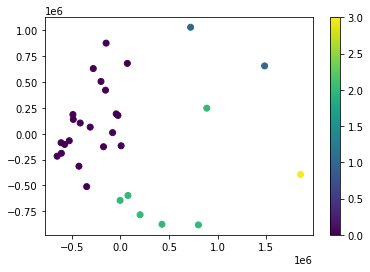

In [289]:
# Dimensionality reduction to 2-dimensional space 
# for visualization of clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(matrix)
reduced = pd.DataFrame(reduced)
plt.scatter(reduced[0], reduced[1], c=clusters);
plt.colorbar();

In [290]:
# Creating a mapping between airports and clusters

clusters_dict = dict(zip(matrix.index,clusters))
clusters_series = pd.Series(clusters_dict).sort_values()
clusters_series.name = 'cluster'

In [291]:
# Sorting top airports by their cluster number 

top_airports.sort(key=lambda x: clusters_dict[x])

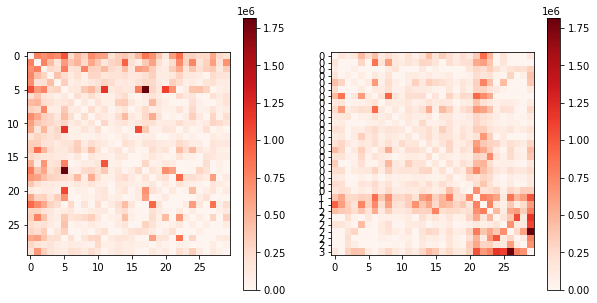

In [292]:
# Visualizing the adjacency matrix before and after sorting by clusters

fig, axs = plt.subplots(1, 2, figsize=(10,5))

img = axs[0].imshow(matrix, cmap='Reds');
fig.colorbar(img, ax=axs[0]);

matrix_2 = matrix.loc[clusters_series.index, clusters_series.index]
img = axs[1].imshow(matrix_2, cmap='Reds');
axs[1].set_yticks(range(len(matrix_2)), clusters_series.values);
fig.colorbar(img, ax=axs[1]);


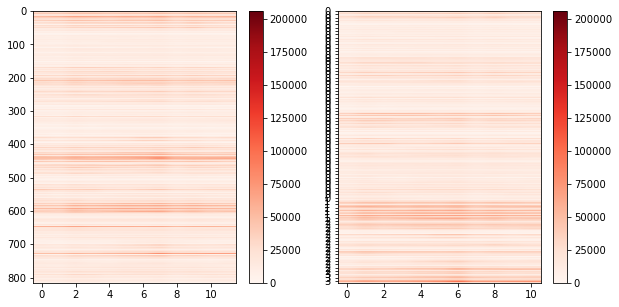

In [297]:
# Visualizing the carpet plot before and after sorting by clusters

carpet = one_year.pivot_table(index=['Origin_airport', 'Destination_airport'], \
    columns='Fly_date', values='Passengers', aggfunc='sum').fillna(0).reset_index()

carpet2 = pd.merge(clusters_series, carpet, right_on='Origin_airport', left_index=True)
carpet2 = carpet2.sort_values(['cluster', 'Origin_airport'])
carpet2.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
img = axs[0].imshow(carpet[carpet.columns[2:]], cmap='Reds', aspect='auto');
fig.colorbar(img, ax=axs[0]);
img = axs[1].imshow(carpet2[carpet.columns[3:]], cmap='Reds', aspect='auto');
axs[1].set_yticks(carpet2.index[::10], carpet2['cluster'][::10].values);
fig.colorbar(img, ax=axs[1]);

## Flights for airport grid

In [302]:
time_steps = 12

In [294]:
one_year['Fly_date'].replace(date_encoding, inplace=True)
one_year['Fly_date'] = one_year['Fly_date'] + 1

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_44831/85588585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date'].replace(date_encoding, inplace=True)
/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_44831/85588585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date'] = one_year['Fly_date'] + 1


In [295]:
merged  = pd.merge(one_year, clusters_series, left_on='Origin_airport', right_index=True)
merged2 = pd.merge(merged, clusters_series, left_on='Destination_airport', right_index=True, suffixes=('_origin', '_destination'))

In [313]:
cluster_stats = merged2.groupby(['cluster_origin', 'cluster_destination']).apply(\
                    lambda x: pd.Series({'size': x.size, 'sum': x['Passengers'].sum()}))#.reset_index()

cluster_stats.sort_values(['cluster_origin', 'size'], ascending=False)

size       sum
cluster_origin cluster_destination                 
3              0                     1404   4305433
               2                      432   6330846
               1                      144   1655696
2              0                     7086  15120451
               2                     2160  11492284
               1                      864   5044556
               3                      432   6302130
1              0                     3024  18088347
               2                      864   5016007
               1                      144   1543300
               3                      144   1643068
0              0                    27534  61068124
               2                     7014  15361653
               1                     3024  17821464
               3                     1368   4205723

In [300]:
merged2[['cluster_origin', 'cluster_destination']].groupby(['cluster_origin', 'cluster_destination']).size().reset_index()

,cluster_origin,cluster_destination,0
0,0,0,4589
1,0,1,504
2,0,2,1169
3,0,3,228
4,1,0,504
5,1,1,24
6,1,2,144
7,1,3,24
8,2,0,1181
9,2,1,144


In [301]:
merged2[['cluster_origin', 'cluster_destination', 'Passengers']].groupby(['cluster_origin', 'cluster_destination']).sum().reset_index()

,cluster_origin,cluster_destination,Passengers
0,0,0,61068124
1,0,1,17821464
2,0,2,15361653
3,0,3,4205723
4,1,0,18088347
5,1,1,1543300
6,1,2,5016007
7,1,3,1643068
8,2,0,15120451
9,2,1,5044556


In [237]:
one_year['Origin_airport']      = one_year.apply(lambda x: "%s_%s" % (x['Origin_airport'],      x['Fly_date']), axis=1)
one_year['Destination_airport'] = one_year.apply(lambda x: "%s_%s" % (x['Destination_airport'], x['Fly_date']+1), axis=1)
del one_year['Fly_date']
one_year.columns = ['origin', 'destination', 'count']
one_year.to_csv('flights.csv', index=False)

## Grid Positioning 

$ (t*c_x, i*c_y)$ where $i \in [0, N]$  and $t \in [0, T]$ such that $N$ is number of nodes (e.g. airports) and $T$ is time (e.g. days). 

$c_x$ and $c_y$ are constants that define the distance distance from origin $(0, 0)$ as well as between other nodes. 

In [254]:
locs = []

# width = 960
# height = 600
time_steps = 12
c_x = 80
c_y = 20
# for k in airport_encoding:
    # i = airport_encoding[k]
for i, k in enumerate(clusters_series.index):
    for t in range(1, time_steps+2): #list(date_encoding.values()):
        locs.append(["%s_%s" % (k,t), (t+1)*c_x, (i+1)*c_y, clusters_dict[k]])

locs_df = pd.DataFrame(locs)
locs_df.columns = ['iata', 'latitude', 'longitude', 'cluster']
# locs_df['latitude']  = locs_df['latitude']
# locs_df['latitude']  = locs_df['latitude']
locs_df.to_csv('grid_locs.csv', index=False)

In [248]:
clusters_series

DTW    0
LGA    0
DCA    0
BOS    0
MCO    0
IND    0
PIT    0
MEM    0
EWR    0
PHL    0
CLT    0
MIA    0
CLE    0
TPA    0
BWI    0
STL    0
MSP    0
IAH    0
CVG    0
SLC    0
IAD    0
DFW    1
ATL    1
ORD    1
LAX    2
SFO    3
JFK    3
LAS    3
SEA    3
PHX    3
Name: cluster, dtype: int32

In [258]:
# pd.merge(pd.Series(top_airports), clusters_series, left_on=0, right_index=True)

In [240]:
top_airports.sort(key=lambda x: clusters_dict[x])